In [45]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate, cross_val_predict, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.linear_model import ElasticNet
import lightgbm as lgb
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor

# Carga y preparacion de datos

In [105]:
# Cargar el DataFrame desde el archivo
with open('../Pickles/df_final.pickle', 'rb') as archivo:
    df = pickle.load(archivo)

In [106]:
# Establecer la opción para mostrar todas las columnas
pd.set_option('display.max_columns', None)

In [107]:
nombres=df.drop(['CompTotal'], axis=1).columns

In [108]:
df.isnull().values.any()

False

In [109]:
# 3. IQR
Q1 = df['CompTotal'].quantile(0.25)
Q3 = df['CompTotal'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior_iqr = Q1 - 1.5 * IQR
limite_superior_iqr = Q3 + 1.5 * IQR

print(f"IQR: {IQR}")
print(f"Límite inferior (IQR): {limite_inferior_iqr}")
print(f"Límite superior (IQR): {limite_superior_iqr}")

# 4. Percentiles
percentil_3 = df['CompTotal'].quantile(0.03)
percentil_95 = df['CompTotal'].quantile(0.95)

print(f"Percentil 3: {percentil_3}")
print(f"Percentil 95: {percentil_95}")

# Del boxplot y el IQR, ya podemos identificar algunos outliers.
# Usemos ahora los límites calculados para filtrar el DataFrame

# Filtrar outliers usando IQR
df_filtrado_iqr = df[(df['CompTotal'] >= limite_inferior_iqr) & (df['CompTotal'] <= limite_superior_iqr)]

# Filtrar outliers usando percentiles
df_filtrado_percentiles = df[(df['CompTotal'] >= percentil_3) & (df['CompTotal'] <= percentil_95)]

# Comparar tamaños de los DataFrames
print(f"\nTamaño del DataFrame original: {df.shape}")
print(f"Tamaño del DataFrame filtrado con IQR: {df_filtrado_iqr.shape}")
print(f"Tamaño del DataFrame filtrado con percentiles: {df_filtrado_percentiles.shape}")

IQR: 33597.5
Límite inferior (IQR): -16993.75
Límite superior (IQR): 117396.25
Percentil 3: 18000.0
Percentil 95: 120000.0

Tamaño del DataFrame original: (1934, 397)
Tamaño del DataFrame filtrado con IQR: (1817, 397)
Tamaño del DataFrame filtrado con percentiles: (1801, 397)


**Interpretación y comparación:**

- IQR: Sugiere un límite superior de 117396.25 euros.
- Percentiles: Sugiere el límine superior en 120000 euros (con el percentil 95).

- Elección del límite inferior:
    - El percentil 3 (18000) es concordante con los límites mínimo establecido en el convenio colectivo del sector (17.599,36 para la categoría mínima), por lo que usaré ese mínimo. 
- Elección del límite superior:
    - El IQR da un límite inferior similar (-16993.75) que el percentil 3, aunque por las razones expuestas se utilizará el límite establecido en Conveio colectivo. 
    - Teniendo en cuenta el análisis visual del gráfico de densidad, éste sugiere que la "cola" empieza alrededor de 150,000.
    - Usar 120000 euros como límite superior parece un valor razonable que permite eliminar una buena parte de los outliers, eliminando tan solo el 5% de los datos.

Como resultado del análisis, y como se puede ver en los gráficos, se ha decidido utilizar el método percentil para la eliminación de outliers, ya que proporciona un equilibrio entre la eliminación de valores extremos y la conservación de datos (se eliminan 132 datos, lo que representa un 6.83% de los datos).

La decisión de utilizar este método y este porcentaje de eliminación se basa en la observación de que los valores eliminados se encuentran en las colas de la distribución y su inclusión podría afectar negativamente el rendimiento del modelo.

In [110]:
limite_inferior = 18000
limite_superior = 120000

df_filtrado = df[(df['CompTotal'] >= limite_inferior) & (df['CompTotal'] <= limite_superior)]

print(f"Tamaño del DataFrame original: {df.shape}")
print(f"Tamaño del DataFrame filtrado: {df_filtrado.shape}")

df = df_filtrado

Tamaño del DataFrame original: (1934, 397)
Tamaño del DataFrame filtrado: (1801, 397)


*Nota*: Se exploraron otras técnicas para la división de los datos. Una de ellas fue el uso de KMeans, un algoritmo de clustering, con el objetivo de segmentar los datos y mejorar la capacidad predictiva de los modelos al permitirles aprender patrones específicos de cada grupo.

Se utilizó el algoritmo KMeans para agrupar los datos, tomando como base la variable "CompTotal" (salario anual total). Inicialmente, se probaron configuraciones con dos clústeres, con la intención de separar los datos en grupos de salarios "normales" y "altos". Sin embargo, el análisis de la distribución resultante mostró que un clúster concentraba la mayoría de las observaciones, mientras que el otro agrupaba una pequeña cantidad de salarios significativamente más altos.

Dado que el clúster de salarios altos contenía un número reducido de muestras, lo que dificultaba la generalización del modelo, se decidió prescindir de la segmentación por clústeres y mantener un solo conjunto de datos que englobara la mayoría de los salarios, dejando fuera los valores atípicos o outliers, que distorsionaban el rendimiento de los modelos. 

In [111]:
df.describe()

,MainBranch,EdLevel,YearsCode,YearsCodePro,PurchaseInfluence,CompTotal,AISelect,AISent,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,Age_Grouped_Adulto,Age_Grouped_Joven,Age_Grouped_Senior,is_full_time,is_part_time,is_independent,num_jobs,is_other_employment,Remote_grouped_In-person,Remote_grouped_Remote/Hybrid,CodingActivities_encoded,LearnCode_encoded,LearnCodeOnline_encoded,DevType_encoded,OrgSize_Grouped_Desconocido,OrgSize_Grouped_Grande,OrgSize_Grouped_Mediana,OrgSize_Grouped_Muy Pequeña,OrgSize_Grouped_Pequeña,Android-based,Linux-based,MacOS,Otros,Windows-based,Industry_Category_Industria y Energía,Industry_Category_Otros Servicios,Industry_Category_Salud y Educación,Industry_Category_Servicios Financieros,Industry_Category_Tecnología y Servicios Digitales,BuyNewTool_Ask a generative AI tool,BuyNewTool_Ask developers I know/work with,BuyNewTool_Other,BuyNewTool_Other (please specify):,BuyNewTool_Read ratings or reviews on third party sites like G2 Crowd,BuyNewTool_Research companies that have advertised on sites I visit,BuyNewTool_Research companies that have emailed me,BuyNewTool_Start a free trial,BuyNewTool_Visit developer communities like Stack Overflow,LanguageHaveWorkedWith_,LanguageHaveWorkedWith_Ada,LanguageHaveWorkedWith_Apex,LanguageHaveWorkedWith_Assembly,LanguageHaveWorkedWith_Bash/Shell (all shells),LanguageHaveWorkedWith_C,LanguageHaveWorkedWith_C#,LanguageHaveWorkedWith_C++,LanguageHaveWorkedWith_Clojure,LanguageHaveWorkedWith_Cobol,LanguageHaveWorkedWith_Crystal,LanguageHaveWorkedWith_Dart,LanguageHaveWorkedWith_Delphi,LanguageHaveWorkedWith_Elixir,LanguageHaveWorkedWith_Erlang,LanguageHaveWorkedWith_F#,LanguageHaveWorkedWith_Fortran,LanguageHaveWorkedWith_GDScript,LanguageHaveWorkedWith_Go,LanguageHaveWorkedWith_Groovy,LanguageHaveWorkedWith_HTML/CSS,LanguageHaveWorkedWith_Haskell,LanguageHaveWorkedWith_Java,LanguageHaveWorkedWith_JavaScript,LanguageHaveWorkedWith_Julia,LanguageHaveWorkedWith_Kotlin,LanguageHaveWorkedWith_Lisp,LanguageHaveWorkedWith_Lua,LanguageHaveWorkedWith_MATLAB,LanguageHaveWorkedWith_Nim,LanguageHaveWorkedWith_OCaml,LanguageHaveWorkedWith_Objective-C,LanguageHaveWorkedWith_PHP,LanguageHaveWorkedWith_Perl,LanguageHaveWorkedWith_PowerShell,LanguageHaveWorkedWith_Prolog,LanguageHaveWorkedWith_Python,LanguageHaveWorkedWith_R,LanguageHaveWorkedWith_Ruby,LanguageHaveWorkedWith_Rust,LanguageHaveWorkedWith_SQL,LanguageHaveWorkedWith_Scala,LanguageHaveWorkedWith_Solidity,LanguageHaveWorkedWith_Swift,LanguageHaveWorkedWith_TypeScript,LanguageHaveWorkedWith_VBA,LanguageHaveWorkedWith_Visual Basic (.Net),LanguageHaveWorkedWith_Zig,LanguageWantToWorkWith_,LanguageWantToWorkWith_Ada,LanguageWantToWorkWith_Apex,LanguageWantToWorkWith_Assembly,LanguageWantToWorkWith_Bash/Shell (all shells),LanguageWantToWorkWith_C,LanguageWantToWorkWith_C#,LanguageWantToWorkWith_C++,LanguageWantToWorkWith_Clojure,LanguageWantToWorkWith_Crystal,LanguageWantToWorkWith_Dart,LanguageWantToWorkWith_Delphi,LanguageWantToWorkWith_Elixir,LanguageWantToWorkWith_Erlang,LanguageWantToWorkWith_F#,LanguageWantToWorkWith_Fortran,LanguageWantToWorkWith_GDScript,LanguageWantToWorkWith_Go,LanguageWantToWorkWith_Groovy,LanguageWantToWorkWith_HTML/CSS,LanguageWantToWorkWith_Haskell,LanguageWantToWorkWith_Java,LanguageWantToWorkWith_JavaScript,LanguageWantToWorkWith_Julia,LanguageWantToWorkWith_Kotlin,LanguageWantToWorkWith_Lisp,LanguageWantToWorkWith_Lua,LanguageWantToWorkWith_MATLAB,LanguageWantToWorkWith_Nim,LanguageWantToWorkWith_OCaml,LanguageWantToWorkWith_Objective-C,LanguageWantToWorkWith_PHP,LanguageWantToWorkWith_Perl,LanguageWantToWorkWith_PowerShell,LanguageWantToWorkWith_Prolog,LanguageWantToWorkWith_Python,LanguageWantToWorkWith_R,LanguageWantToWorkWith_Ruby,LanguageWantToWorkWith_Rust,LanguageWantToWorkWith_SQL,LanguageWantToWorkWith_Scala,LanguageWantToWorkWith_Solidity,LanguageWantToWorkWith_Swift,LanguageWantToWorkWith_TypeScript,LanguageWantToWorkWith_VBA,LanguageWantToWorkWith_Visual Basic (.Net)

**Problema en la Distribución Original:** 

La distribución original de la variable CompTotal presentaba un marcado sesgo positivo (sesgo a la derecha). Esto significa que había una mayor concentración de valores en el extremo inferior del rango salarial, con una cola larga extendiéndose hacia valores más altos. Además, se insinuaba una posible multimodalidad, sugiriendo la presencia de múltiples grupos con diferentes rangos salariales dentro de la distribución. Este tipo de distribución puede ser problemático para muchos algoritmos de machine learning que asumen normalidad o simetría en los datos, pudiendo afectar negativamente al rendimiento del modelo.

*Transformación Aplicada:*

Para abordar los problemas de sesgo y no normalidad, se aplicó una transformación logarítmica a la variable CompTotal. Específicamente, se utilizó la función log1p, que calcula el logaritmo natural de (1 + x), lo cual es útil para manejar valores que pueden ser cero.

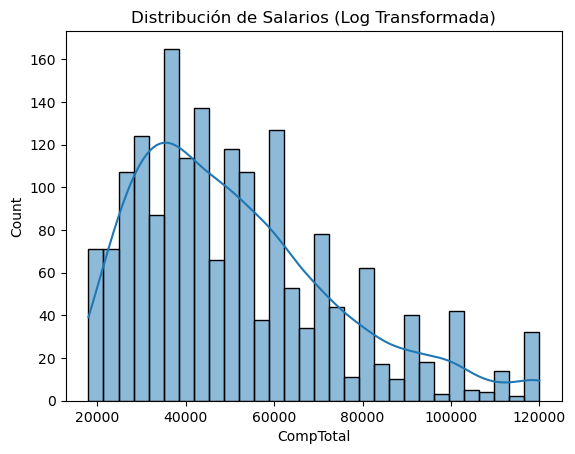

In [112]:
# Target sin transformacion:
sns.histplot(df['CompTotal'], bins=30, kde=True)
plt.title('Distribución de Salarios (Log Transformada)')
plt.show()

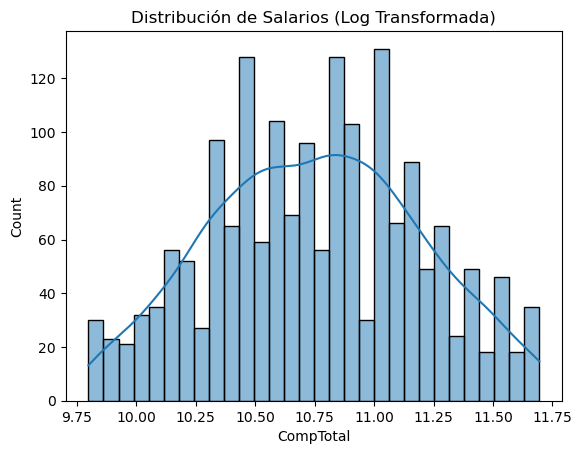

In [113]:
# Target con transformacion logaritmica
df['CompTotal'] = np.log1p(df['CompTotal'])
sns.histplot(df['CompTotal'], bins=30, kde=True)
plt.title('Distribución de Salarios (Log Transformada)')
plt.show()

*Conclusiones:*

La transformación logarítmica ha sido muy efectiva para normalizar la distribución de la variable CompTotal. La distribución transformada es más simétrica, se aproxima más a una distribución normal y es más adecuada para su uso en modelos de machine learning que asumen estas características en los datos. La reducción del sesgo y la mitigación de la multimodalidad son indicadores claros del éxito de la transformación.
________________________________________________________________________________________________

Ya esta todo listo para dividir mis conjuntos de train y test.

In [114]:
y = df['CompTotal']

In [115]:
df = df.drop(columns=['CompTotal'], axis=1)

In [116]:
columnas = df.columns

In [117]:
# Dividir los datos en train y test
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)

Escalo los datos 

In [118]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Modelos

Empiezo con un modelo de regresión lineal como baseline

In [121]:
# Inicialización del modelo lineal
linear_model = LinearRegression()

# Definir el número de folds y la estrategia de validación cruzada
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Listas para almacenar las métricas de cada fold
r2_scores = []
mse_scores = []
rmse_scores = []
mae_scores = []
mape_scores = []

# Bucle de validación cruzada
for train_index, val_index in cv.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Entrenar el modelo en el fold actual
    linear_model.fit(X_train_fold, y_train_fold)

    # Hacer predicciones en el fold de validación (en la escala logarítmica)
    y_val_pred_log = linear_model.predict(X_val_fold)

    # Aplicar la transformación inversa a las predicciones y a los valores reales
    y_val_pred = np.expm1(y_val_pred_log)
    y_val_original = np.expm1(y_val_fold)

    # Calcular métricas en la escala original
    r2_scores.append(r2_score(y_val_original, y_val_pred))
    mse_scores.append(mean_squared_error(y_val_original, y_val_pred))
    rmse_scores.append(np.sqrt(mse_scores[-1]))
    mae_scores.append(mean_absolute_error(y_val_original, y_val_pred))
    mape_scores.append(np.mean(np.abs((y_val_original - y_val_pred) / y_val_original)) * 100)

# Calcular los promedios de las métricas
mean_r2_cv = np.mean(r2_scores)
mean_mse_cv = np.mean(mse_scores)
mean_rmse_cv = np.mean(rmse_scores)
mean_mae_cv = np.mean(mae_scores)
mean_mape_cv = np.mean(mape_scores)

# Imprimir las métricas
print("=== Métricas de Cross-Validation ===")
print(f"R² (promedio CV): {mean_r2_cv:.4f}")
print(f"MSE (promedio CV): {mean_mse_cv:.4f}")
print(f"RMSE (promedio CV): {mean_rmse_cv:.4f}")
print(f"MAE (promedio CV): {mean_mae_cv:.4f}")
print(f"MAPE (promedio CV): {mean_mape_cv:.4f}")

=== Métricas de Cross-Validation ===
R² (promedio CV): 0.3215
MSE (promedio CV): 352465515.5836
RMSE (promedio CV): 18734.6133
MAE (promedio CV): 13310.9341
MAPE (promedio CV): 27.0945


Pruebo con un Random Forest con hiperparámetros por defecto sin transformación logarítmica. 

Las métricas dan muy mal, así que volvemos a utilizar la transformación logarítmica, pero luego hay que hacer la transformación inversa. 

In [100]:
# # Crear un modelo de Random Forest
# rf_model = RandomForestRegressor(random_state=42)

# cv = 5  # Número de folds
# r2_scores = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring='r2')
# mse_scores = -cross_val_score(rf_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
# mae_scores = -cross_val_score(rf_model, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')

# # Promedios de métricas en CV
# mean_r2_cv = np.mean(r2_scores)
# mean_mse_cv = np.mean(mse_scores)
# mean_rmse_cv = np.sqrt(mean_mse_cv)
# mean_mae_cv = np.mean(mae_scores)

# # Métricas de Cross-Validation
# print("=== Métricas de Cross-Validation ===")
# print(f"R² (promedio CV): {mean_r2_cv:.4f}")
# print(f"MSE (promedio CV): {mean_mse_cv:.4f}")
# print(f"RMSE (promedio CV): {mean_rmse_cv:.4f}")
# print(f"MAE (promedio CV): {mean_mae_cv:.4f}")

# output: === Métricas de Cross-Validation ===> Y SIN TRANSFORMACION LOGARITMICA 
# R² (promedio CV): 0.5866
# MSE (promedio CV): 213457640.8716
# RMSE (promedio CV): 14610.1896
# MAE (promedio CV): 10237.3762

In [99]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

# Asegúrate de convertir los arrays de numpy a pandas DataFrame y Series si es necesario
X_train = pd.DataFrame(X_train)  # Si X_train es un ndarray, conviértelo en DataFrame
y_train = pd.Series(y_train)  # Si y_train es un ndarray, conviértelo en Series

# Crear un modelo de Random Forest
rf_model = RandomForestRegressor(random_state=42)

cv = 5  # Número de folds

# Inicializamos listas para guardar las métricas de cada fold
r2_scores = []
mse_scores = []
mae_scores = []

# Realizar la validación cruzada
kf = KFold(n_splits=cv, shuffle=True, random_state=42)
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]  # Usar .iloc con DataFrame
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]  # Usar .iloc con Series
    
    # Entrenar el modelo en el fold
    rf_model.fit(X_train_fold, y_train_fold)
    
    # Predecir en el conjunto de validación
    y_val_pred_log = rf_model.predict(X_val_fold)
    
    # Revertir la transformación logarítmica
    y_val_pred = np.expm1(y_val_pred_log)
    y_val_actual = np.expm1(y_val_fold)
    
    # Calcular las métricas para este fold
    r2 = r2_score(y_val_actual, y_val_pred)
    mse = mean_squared_error(y_val_actual, y_val_pred)
    mae = mean_absolute_error(y_val_actual, y_val_pred)
    
    # Guardar las métricas en las listas
    r2_scores.append(r2)
    mse_scores.append(mse)
    mae_scores.append(mae)

# Promedios de métricas en CV
mean_r2_cv = np.mean(r2_scores)
mean_mse_cv = np.mean(mse_scores)
mean_rmse_cv = np.sqrt(mean_mse_cv)
mean_mae_cv = np.mean(mae_scores)

# Métricas de Cross-Validation
print("=== Métricas de Cross-Validation ===")
print(f"R² (promedio CV): {mean_r2_cv:.4f}")
print(f"MSE (promedio CV): {mean_mse_cv:.4f}")
print(f"RMSE (promedio CV): {mean_rmse_cv:.4f}")
print(f"MAE (promedio CV): {mean_mae_cv:.4f}")

=== Métricas de Cross-Validation ===
R² (promedio CV): 0.5823
MSE (promedio CV): 217730247.8466
RMSE (promedio CV): 14755.6853
MAE (promedio CV): 10014.7741


Pruebo con un GridSearch los mejores hiperparámetros

In [120]:
# Asegúrate de que X_train y y_train sean DataFrame y Series de pandas
X_train = pd.DataFrame(X_train)  # Si X_train es un ndarray, conviértelo en DataFrame
y_train = pd.Series(y_train)  # Si y_train es un ndarray, conviértelo en Series

# Crear un modelo de Random Forest
rf_model = RandomForestRegressor(random_state=42)

# Definir el grid de hiperparámetros para GridSearchCV
param_grid = {
    'n_estimators': [300, 500],  # Número de árboles en el bosque
    'max_depth': [15, 30, None],  # Profundidad máxima de los árboles
    'min_samples_split': [1, 2, 3],  # Mínimo número de muestras para dividir un nodo
    'min_samples_leaf': [1],  # Mínimo número de muestras por hoja
    'max_features': ['sqrt']  # Número de características a considerar para cada división
}
{'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
# Configuración de GridSearchCV con validación cruzada
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=1, scoring='neg_mean_absolute_error')

# Realizar el GridSearchCV
grid_search.fit(X_train, y_train)

# Imprimir los mejores parámetros encontrados
print(f"Mejores parámetros: {grid_search.best_params_}")

# Mejor modelo después de GridSearchCV
best_rf_model = grid_search.best_estimator_

# Realizar la validación cruzada
cv = 5
r2_scores = []
mse_scores = []
mae_scores = []

kf = KFold(n_splits=cv, shuffle=True, random_state=42)
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Entrenar el modelo en el fold
    best_rf_model.fit(X_train_fold, y_train_fold)
    
    # Predecir en el conjunto de validación
    y_val_pred_log = best_rf_model.predict(X_val_fold)
    
    # Revertir la transformación logarítmica
    y_val_pred = np.expm1(y_val_pred_log)
    y_val_actual = np.expm1(y_val_fold)
    
    # Calcular las métricas para este fold
    r2 = r2_score(y_val_actual, y_val_pred)
    mse = mean_squared_error(y_val_actual, y_val_pred)
    mae = mean_absolute_error(y_val_actual, y_val_pred)
    
    # Guardar las métricas en las listas
    r2_scores.append(r2)
    mse_scores.append(mse)
    mae_scores.append(mae)

# Promedios de métricas en CV
mean_r2_cv = np.mean(r2_scores)
mean_mse_cv = np.mean(mse_scores)
mean_rmse_cv = np.sqrt(mean_mse_cv)
mean_mae_cv = np.mean(mae_scores)

# Métricas de Cross-Validation
print("=== Métricas de Cross-Validation ===")
print(f"R² (promedio CV): {mean_r2_cv:.4f}")
print(f"MSE (promedio CV): {mean_mse_cv:.4f}")
print(f"RMSE (promedio CV): {mean_rmse_cv:.4f}")
print(f"MAE (promedio CV): {mean_mae_cv:.4f}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits


c:\Users\emita\.conda\envs\proyecto_ml\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
30 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\emita\.conda\envs\proyecto_ml\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\emita\.conda\envs\proyecto_ml\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\emita\.conda\envs\proyecto_ml\lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constrai

Mejores parámetros: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 500}
=== Métricas de Cross-Validation ===
R² (promedio CV): 0.4568
MSE (promedio CV): 283364132.1812
RMSE (promedio CV): 16833.4231
MAE (promedio CV): 11927.9278


Mejores parámetros: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
=== Métricas de Cross-Validation ===
R² (promedio CV): 0.4471
MSE (promedio CV): 288456228.1446
RMSE (promedio CV): 16983.9992
MAE (promedio CV): 12063.8331

Pruebo con XGBoosting

In [123]:
# Asegúrate de que X_train y y_train sean DataFrame y Series de pandas
X_train = pd.DataFrame(X_train)  # Si X_train es un ndarray, conviértelo en DataFrame
y_train = pd.Series(y_train)  # Si y_train es un ndarray, conviértelo en Series

# Crear un modelo de Random Forest
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Definir el grid de hiperparámetros para GridSearchCV
param_grid = {
    'n_estimators': [200, 300],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [3, 5],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.9],
    'gamma': [0.1, 0.3],
}
# Configuración de GridSearchCV con validación cruzada
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_mean_absolute_error', cv=3, n_jobs=-1, verbose=1)
# Realizar el GridSearchCV
grid_search.fit(X_train, y_train)

# Imprimir los mejores parámetros encontrados
print(f"Mejores parámetros: {grid_search.best_params_}")

# Mejor modelo después de GridSearchCV
xgb_model = grid_search.best_estimator_

# Realizar la validación cruzada
cv = 5
r2_scores = []
mse_scores = []
mae_scores = []

kf = KFold(n_splits=cv, shuffle=True, random_state=42)
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Entrenar el modelo en el fold
    xgb_model.fit(X_train_fold, y_train_fold)
    
    # Predecir en el conjunto de validación
    y_val_pred_log = xgb_model.predict(X_val_fold)
    
    # Revertir la transformación logarítmica
    y_val_pred = np.expm1(y_val_pred_log)
    y_val_actual = np.expm1(y_val_fold)
    
    # Calcular las métricas para este fold
    r2 = r2_score(y_val_actual, y_val_pred)
    mse = mean_squared_error(y_val_actual, y_val_pred)
    mae = mean_absolute_error(y_val_actual, y_val_pred)
    
    # Guardar las métricas en las listas
    r2_scores.append(r2)
    mse_scores.append(mse)
    mae_scores.append(mae)

# Promedios de métricas en CV
mean_r2_cv = np.mean(r2_scores)
mean_mse_cv = np.mean(mse_scores)
mean_rmse_cv = np.sqrt(mean_mse_cv)
mean_mae_cv = np.mean(mae_scores)

# Métricas de Cross-Validation
print("=== Métricas de Cross-Validation ===")
print(f"R² (promedio CV): {mean_r2_cv:.4f}")
print(f"MSE (promedio CV): {mean_mse_cv:.4f}")
print(f"RMSE (promedio CV): {mean_rmse_cv:.4f}")
print(f"MAE (promedio CV): {mean_mae_cv:.4f}")

Fitting 3 folds for each of 288 candidates, totalling 864 fits


KeyboardInterrupt: 